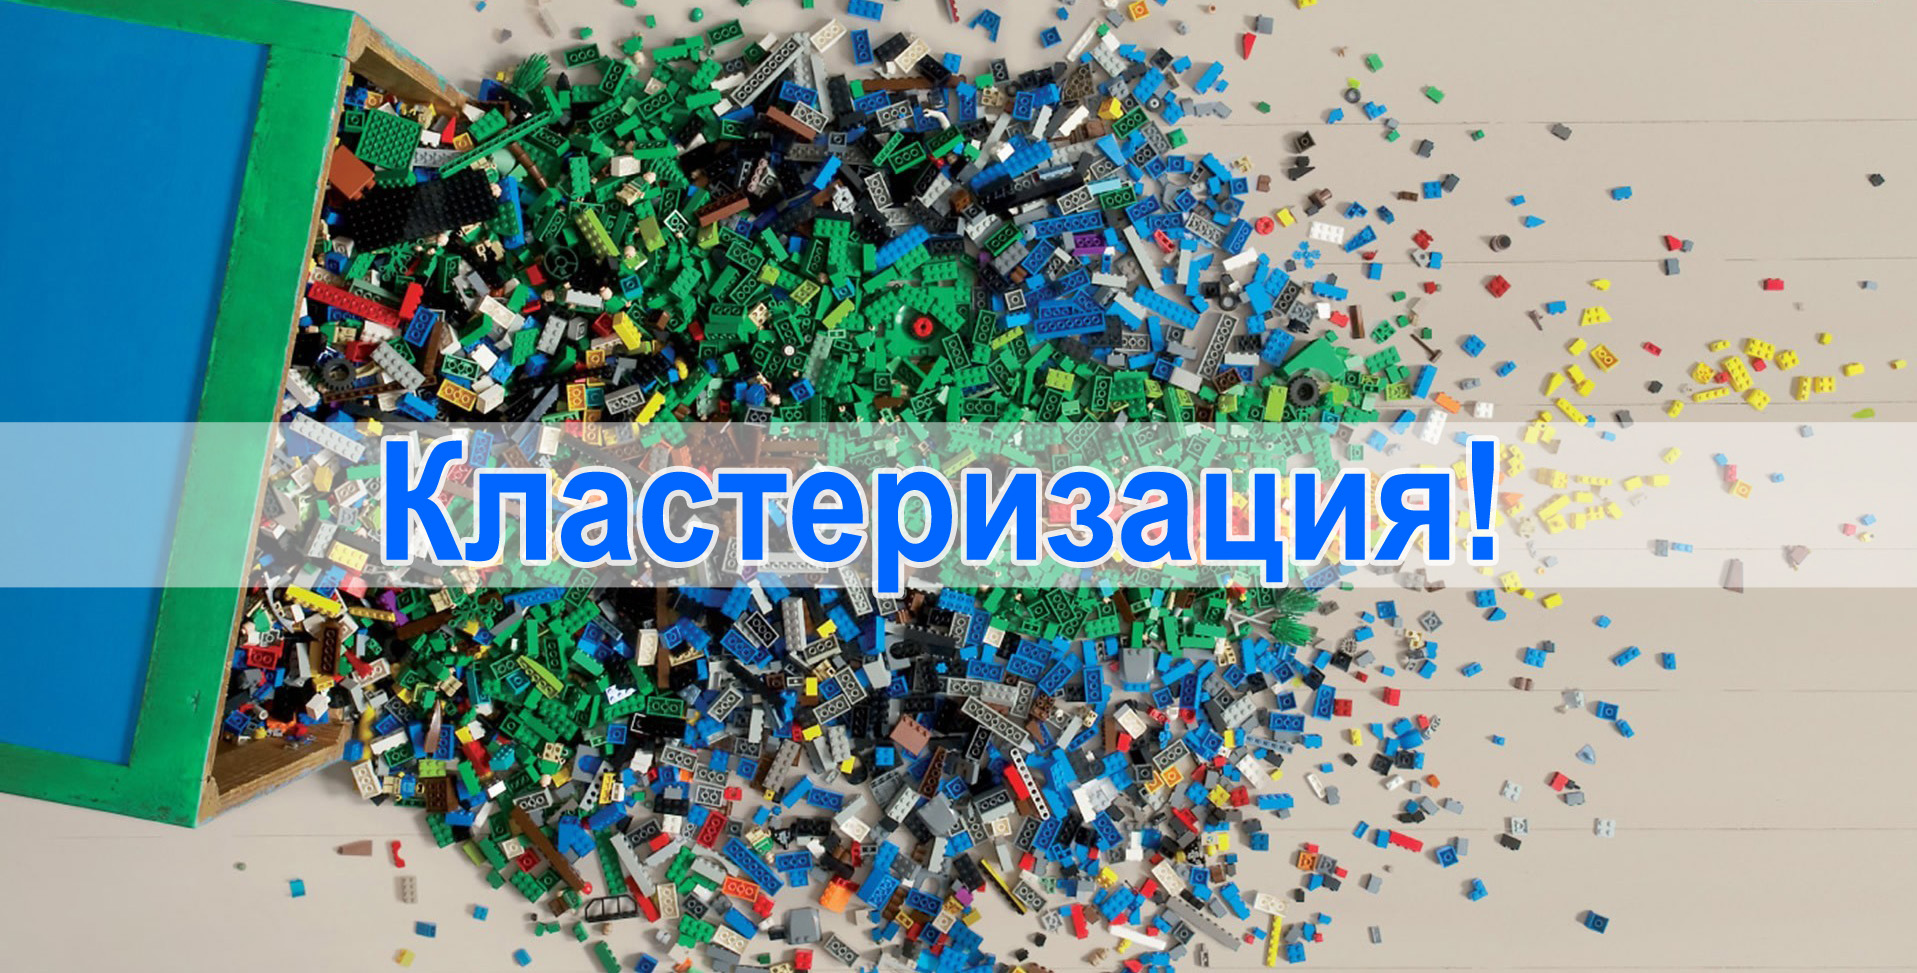

### Легенда

Предположим, к нам пришёл заказчик, которому необходимо проанализировать клиентов торгового центра и выделить разные группы покупателей, чтобы понять, как дальше развивать услуги торгового центра, магазины каких сегментов открывать.

В предоставленном нам датасете содержится основная информация о покупателе: идентификатор, возраст, пол, доход, индекс расходов. Индекс расходов считается на основе таких параметров, как поведение клиента и данные о покупках, и принимает значение от 1 до 100.

Также вдатасете содержится информация об истинных метках кластеров для клиентов (они нам пригодятся позже, когда мы будем оценивать точность нашей финальной модели).

In [1]:
# Импортируем библиотеки для работы с данными.
import pandas as pd
from sklearn import preprocessing 
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import completeness_score
from matplotlib import pyplot as plt
import plotly
import plotly.express as px
import seaborn as sns

# загрузим данные
df = pd.read_csv("data/segmented_customers.csv")
# посмотрим на данные
df.head()

CustomerID  Gender   Age  Annual Income (k$)  Spending Score (1-100)  \
0           1    Male  19.0                15.0                    39.0   
1           2    Male  21.0                15.0                    81.0   
2           3  Female  20.0                16.0                     6.0   
3           4  Female  23.0                16.0                    77.0   
4           5  Female  31.0                17.0                    40.0   

   cluster  
0      4.0  
1      3.0  
2      4.0  
3      3.0  
4      4.0

Проведём предобработку данных: удалим пропуски и дубли, признак Gender превратим в бинарный с помощью LabelEncoder:

In [2]:
# Посмотрим, есть ли пропуски в датасете.
df[df.isna().any(axis=1)]

CustomerID  Gender   Age  Annual Income (k$)  Spending Score (1-100)  \
200         201  Female  21.0                 NaN                    40.0   
201         202  Female  30.0               127.0                     NaN   
202         203    Male  80.0                 NaN                    20.0   
203         204    Male   NaN                16.0                   120.0   
204         205  Female   NaN                 9.0                    80.0   

     cluster  
200      0.0  
201      NaN  
202      NaN  
203      NaN  
204      NaN

In [3]:
# Пропусков не так много, поэтому мы можем удалить данные с пропусками.
df = df.dropna()

# Переименуем столбцы для более удобной работы.
df.rename(columns = {'CustomerID' : 'customer_id', 'Gender' : 'gender', 
                    'Age': 'age', 'Annual Income (k$)': 'annual_income', 
                    'Spending Score (1-100)': 'spending_score', }, inplace = True)

In [4]:
# Проверим, есть ли в данных дубликаты.
df[df.duplicated(subset=['customer_id'])]

Empty DataFrame
Columns: [customer_id, gender, age, annual_income, spending_score, cluster]
Index: []

Дубликатов нет, поэтому идём дальше.

Чтобы мы могли визуально оценивать результаты кластеризации, будем проводить её по трём признакам, а именно: годовой заработок, коэффициент покупательской способности и возраст. Визуализируем распределение данных:

In [5]:
# Передаем датафрейм и поля, которые нужно использовать для осей абсцисс, ординат и аппликат.
fig = px.scatter_3d(
    data_frame=df, 
    x = 'age', 
    y = 'annual_income', 
    z = 'spending_score', 
    width=1000,
    height=700
)

# Отображаем график.
fig.show()

Так как нам часто будет требоваться визуализировать результаты кластеризации, напишем для этого функцию. Она будет принимать датафрейм и название столбца датафрейма с результатами кластеризации. Так как нас будут стабильно интересовать три столбца (age, annual_income, spending_score), зафиксируем их названия внутри функции:

In [6]:
def get_3d_visualization(df, clust_res):
    fig = px.scatter_3d(
        data_frame=df, 
        x = 'age', 
        y = 'annual_income', 
        z = 'spending_score', 
        color = clust_res,
        width=1000,
        height=700
    )

    # Возвращаем график.
    return fig

Сохраним признаки, по которым будем проводить моделирование, в переменную X:

In [7]:
X = df[['age', 'annual_income', 'spending_score']]

Как мы видим, данные разрежённые и неоднородные, а значит, применять DBSCAN будет сложно, нужно будет подбирать параметры для кластеризации.

Но, эксперимента ради, попробуем провести DBSCAN-кластеризацию со значениями по умолчанию.

In [8]:
# Запускаем кластеризацию на наших данных.
dbscan_res = DBSCAN().fit_predict(X)
df['dbscan_res'] = dbscan_res
get_3d_visualization(df, 'dbscan_res')

Как видно, алгоритм плохо работает с настройками по умолчанию (посчитал все выбросами), поэтому попробуем изменить их.

Большая часть наших данных разреженные, а чем больше разброс точек в датасете, тем большее значение радиуса вокруг точки (eps) нужно задавать. Так как данные разреженные, попробуем увеличить значение eps до 11 и визуально оценим результат:

In [9]:
#запускаем кластеризацию на наших данных
dbscan = DBSCAN(eps=11, min_samples=5)
clustering_dbscan_res = dbscan.fit_predict(X)
df['dbscan_res_eps_11'] = clustering_dbscan_res

get_3d_visualization(df, 'dbscan_res_eps_11')

Распределение данных неоднородно: в одной области они имеют высокую плотность, в другой области — разряжены. Такие данные не подходят для успешной кластеризации алгоритмом DBSCAN.

Много точек, которые должны относиться к кластеру, были размечены как выбросы (синие точки). Разумеется, данный способ, основанный на плотности, не очень подходит для кластеризации.

Проведём агломеративную кластеризацию, чтобы построить дендрограмму и по ней оценить количество кластеров, на которое можно разделить датасет. Напишем функцию, которая будет принимать количество кластеров и матрицу с признаками:

In [10]:
# Напишем функцию, которая будет проводить алгомеративную кластеризацию.
# На вход она будет принимать X — матрицу с признаками для кластеризации и n_clusters — количество кластеров,
# на выходе будет возвращать список с номерами кластеров.
def get_aggl_clustering(X, n_clusters):
    # Запустим агломеративную кластеризацию.
    agglomerative_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    # Обучим модель агломеративной кластеризации.
    agglomerative_clustering.fit(X)
    # Получим список c информацией, к какому кластеру относятся объекты.
    aggl_prediction = agglomerative_clustering.labels_
    # Вернём список с результатами.
    return aggl_prediction

Теперь проведем агломеративную кластеризацию, воспользовавшись функцией, которую мы только что написали. После этого визуализируем полученную дендрограмму. Количество кластеров для кластеризации укажите равным 3.

In [11]:
get_aggl_clustering(X, n_clusters=3)

df['aggl_prediction'] = get_aggl_clustering(X, n_clusters=3)
get_3d_visualization(df, 'aggl_prediction')

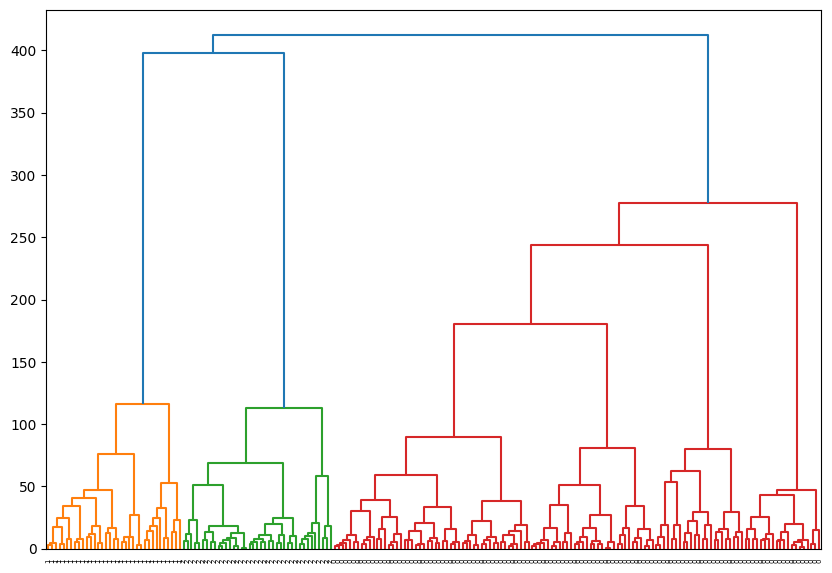

In [12]:
linked = linkage(X, 'ward')
plt.figure(figsize=(10, 7))

dendrogram(linked,
            orientation='top',
            labels=df['aggl_prediction'].to_list(),
            distance_sort='descending',
            show_leaf_counts=True)

plt.show()

Как мы можем судить из дендрограммы, если взять евклидово расстояние между кластерами, равное 150, датасет будет делиться на шесть кластеров.

Давайте визуально оценим, что из этого получилось. Для этого обучим модель агломеративной кластеризации с количеством кластеров, равным 6:

In [13]:
df['aggl_res_6'] = get_aggl_clustering(df[['age', 'annual_income', 'spending_score']], 6)
get_3d_visualization(df, 'aggl_res_6')

Итак, кластеры разделились хорошо.

Теперь воспользуемся коэффициентом силуэта и узнаем оптимальное количество кластеров. Так мы узнаем, верно ли мы подобрали это число, используя дендрограмму.

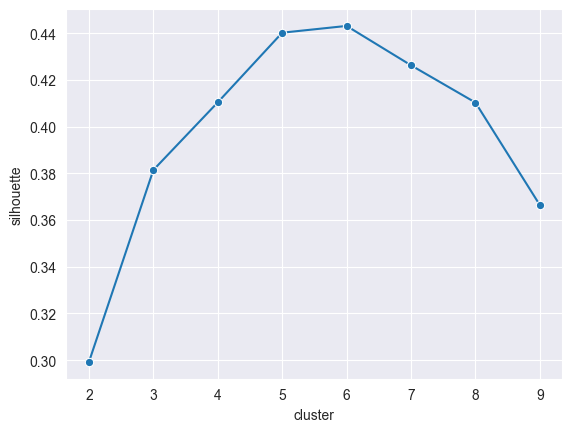

In [16]:
# Напишем функцию для подсчёта коэффициента силуэта.
def get_silhouette_agg_clust(X, cluster_num):
    # Проведём агломеративную кластеризацию с заданным количеством кластеров.
    res = get_aggl_clustering(X, cluster_num)
    # Рассчитаем коэффициент силуэта.
    silhouette = silhouette_score(X, res)
    return silhouette

# Создадим пустой словарь, ключами будут коэффициент силуэта и количество кластеров.
silhouette_res = {"silhouette": [], "cluster": []}

for cluster_num in range(2, 10):
    silhouette_res["silhouette"].append(get_silhouette_agg_clust(X, cluster_num))
    silhouette_res["cluster"].append(cluster_num)

# Сохраним в датафрейм значение силуэта и количество кластеров.
silhouette_df = pd.DataFrame(silhouette_res)

# Установим стиль для визуализиции.
sns.set_style("darkgrid")
# Визуализируем зависимость значения инерции от количества кластеров.
sns.lineplot(data=silhouette_df, x="cluster", y="silhouette", marker="o");

Как видим, пик коэффициента силуэта находится на значении 6. Таким образом, оптимальное количество кластеров — 6.

Теперь рассмотрим столбец cluster: в нём есть информация о том, к какому кластеру должен принадлежать каждый объект из датасета. Значит, мы можем проверить качество кластеризации, посчитав различные метрики.

Нам очень важно, чтобы в ходе кластеризации не были выделены лишние группы, так как это помешает анализу покупателей. Таким образом, нужно, чтобы кластеры получались максимально наполненными элементами.

Поэтому для оценки качества кластеризации мы и воспользуемся метрикой полноты.

In [15]:
print(completeness_score(labels_true=df.cluster, labels_pred=df.aggl_res_6))

0.9012847747610448


Судя по значению метрики, кластеризация проведена отлично: кластеры получились наполненными элементами, а значит данные результаты можно дальше использовать для анализа.